In [312]:
import random 
import pygame
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [313]:
class mapDependenciesGenerator:
    def __init__(self, numberPoints, maxDependencies):
        self.numberPoints = numberPoints
        self.maxDependencies = maxDependencies
        self.dependencies = list()
    
    def getDependencies(self):
        return self.dependencies 

    def generateDependencies(self):
        self.dependencies.append({
            'id': 0,
            'dependencies': [],
            'directDependencies': [],
        })

        for i in range(1, self.numberPoints):
            possibleDependenciesForPoint = self.dependencies
            numberOfPossibilities = len(possibleDependenciesForPoint)
            numberDependenciesForPoint = random.randint(1, min(numberOfPossibilities, 3))

            point = {
                'id': i,
                'dependencies': [],
                'directDependencies': []
            }

            for ii in range(0, numberDependenciesForPoint):
                if len(possibleDependenciesForPoint) == 0:
                    pass 
                
                else:
                    if len(possibleDependenciesForPoint) == 1: 
                        dependencyIndex = 0
                    else: 
                        dependencyIndex = random.randint(0, len(possibleDependenciesForPoint) - 1)

                    dependency = possibleDependenciesForPoint[dependencyIndex]
                    
                    point['dependencies'] = point['dependencies'] + dependency['dependencies'] + [dependency['id']]
                    point['directDependencies'] = point['directDependencies'] + [dependency['id']]

                    possibleDependenciesForPoint = [
                        obj for obj in possibleDependenciesForPoint 
                        if obj['id'] not in point['directDependencies']
                    ]
                    
                    possibleDependenciesForPoint = [
                        obj for obj in possibleDependenciesForPoint 
                        if obj['id'] not in point['dependencies'] and not any(dep in point['directDependencies'] for dep in obj['dependencies'])
                    ]

            if len(point['dependencies']) > 0:
                point['dependencies'] = list(set(point['dependencies']))
            
            self.dependencies.append(point)
    
    def generateDependenciesGraph(self):
        return

In [314]:
class GraphLayout:
    def __init__(self, dependencies):
        G = nx.DiGraph()
        for point in map:
            for dep in point['directDependencies']:
                G.add_edge(dep, point['id'])

        self.graph = G
        self.positions = None
        self.props = list()
    
    def getGraph(self):
        return self.graph 
    
    def getPositions(self):
        return self.positions
        
    def forceDirectedLayout(self, iterations=4000, attraction_strength=0.04, repulsion_strength=200, damping=0.9):
        pos = {node: np.array([random.uniform(-1, 1), random.uniform(-1, 1)]) for node in self.graph.nodes()}
    
        for _ in range(iterations):
            forces = {node: np.array([0.0, 0.0]) for node in self.graph.nodes()}
            for node in self.graph.nodes():
                for other_node in self.graph.nodes():
                    if node != other_node:
                        delta = pos[node] - pos[other_node]
                        distance = np.linalg.norm(delta)
                        if distance == 0:
                            distance = 0.1
                        repulsion_force = repulsion_strength / (distance ** 2)
                        forces[node] += delta / distance * repulsion_force
            
            for edge in self.graph.edges():
                node_a, node_b = edge
                delta = pos[node_a] - pos[node_b]
                distance = np.linalg.norm(delta)
                attraction_force = attraction_strength * distance
                forces[node_a] -= delta / distance * attraction_force
                forces[node_b] += delta / distance * attraction_force
            
            for node in self.graph.nodes():
                pos[node] += forces[node]
                pos[node] *= damping
    
        self.positions = pos
    
    def propImages(self, objects, x_range, y_range):
        for object in objects:
            img = Image.open(object.path)
            img_width, img_height = img.size

            image_fraction = object.image_fraction
            fixed_width = image_fraction * x_range
            fixed_height = fixed_width * (img_height / img_width)
            
            self.props.append({
                'type': object.type,
                'style': object.style,
                'path': object.path,
                'width': fixed_width,
                'height': fixed_height,
                'image_fraction': object.image_fraction
            })

In [315]:
x = mapDependenciesGenerator(20, 3)
graph = GraphLayout(x.generateDependencies())
graph.forceDirectedLayout(iterations=4000)
layout = graph.getPositions()

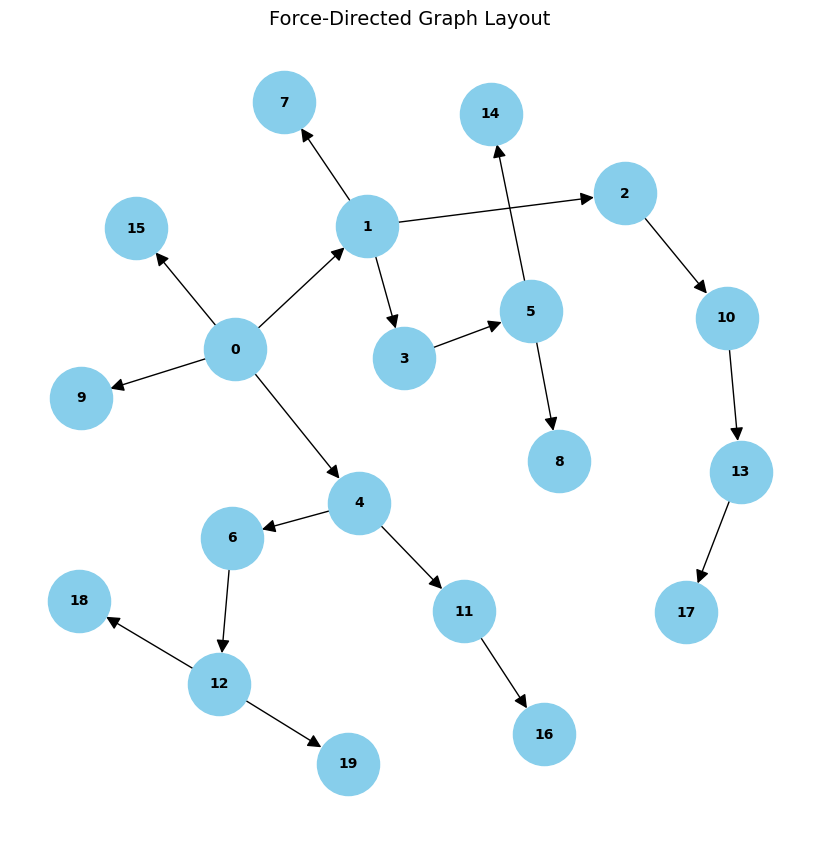

In [316]:
plt.figure(figsize=(8, 8))
nx.draw(graph.getGraph(), layout, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_weight='bold', arrowsize=20)
plt.title("Force-Directed Graph Layout", fontsize=14)
plt.axis("off")
plt.show()

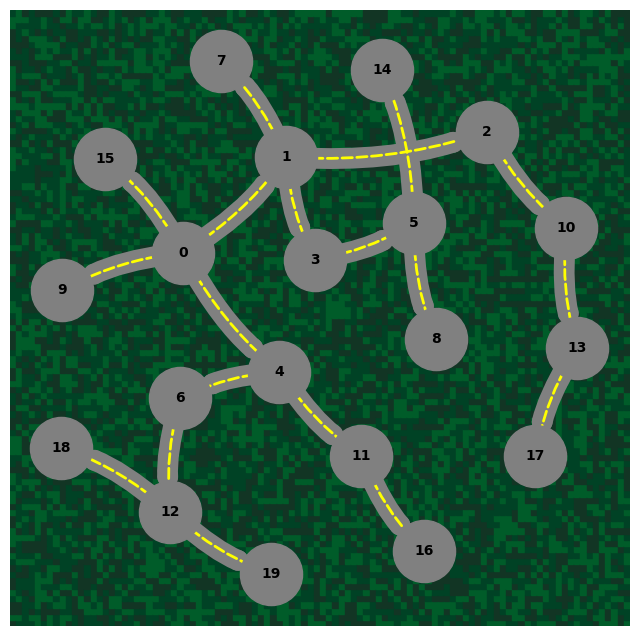

In [319]:
G = graph.getGraph()
custom_layout = layout

x_coords = [pos[0] for pos in custom_layout.values()]
y_coords = [pos[1] for pos in custom_layout.values()]
x_min, x_max = min(x_coords) * 1.2, max(x_coords) * 1.2
y_min, y_max = min(y_coords) * 1.2, max(y_coords) * 1.2

padding = 0.05
x_min, x_max = x_min - padding, x_max + padding
y_min, y_max = y_min - padding, y_max + padding

num_blocks_x = 100
num_blocks_y = 100
block_width = (x_max - x_min) / num_blocks_x
block_height = (y_max - y_min) / num_blocks_y
colors = ['#005C29', '#004225', '#123524']
background = np.random.choice(colors, size=(num_blocks_x, num_blocks_y))

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(num_blocks_x):
    for j in range(num_blocks_y):
        rect = plt.Rectangle(
            (x_min + i * block_width, y_min + j * block_height),
            block_width,
            block_height,
            color=background[i, j]
        )
        ax.add_patch(rect)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='gray',
    width=15,
    arrowsize=0.01,
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='yellow',
    width=2,
    arrowsize=0.01,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='gray',
    node_size=2000
)

nx.draw_networkx_labels(
    G,
    custom_layout,
    ax=ax,
    font_size=10,
    font_weight='bold'
)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')

plt.show()


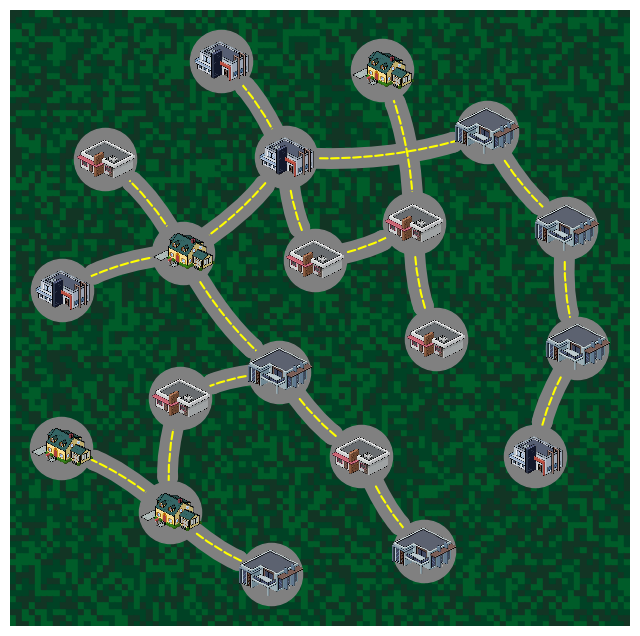

In [349]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
G = graph.getGraph()
custom_layout = layout

x_coords = [pos[0] for pos in custom_layout.values()]
y_coords = [pos[1] for pos in custom_layout.values()]
x_min, x_max = min(x_coords) * 1.2, max(x_coords) * 1.2
y_min, y_max = min(y_coords) * 1.2, max(y_coords) * 1.2

padding = 0.05
x_min, x_max = x_min - padding, x_max + padding
y_min, y_max = y_min - padding, y_max + padding

num_blocks_x = 100
num_blocks_y = 100
block_width = (x_max - x_min) / num_blocks_x
block_height = (y_max - y_min) / num_blocks_y
colors = ['#005C29', '#004225', '#123524']
background = np.random.choice(colors, size=(num_blocks_x, num_blocks_y))

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(num_blocks_x):
    for j in range(num_blocks_y):
        rect = plt.Rectangle(
            (x_min + i * block_width, y_min + j * block_height),
            block_width,
            block_height,
            color=background[i, j]
        )
        ax.add_patch(rect)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='gray',
    width=15,
    arrowsize=0.01,
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='yellow',
    width=1.5,
    arrowsize=0.01,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='gray',
    node_size=2000
)

nx.draw_networkx_labels(
    G,
    custom_layout,
    ax=ax,
    font_size=10,
    font_weight='bold'
)

for node, (x, y) in custom_layout.items():
    img_path = random.choice([
        {'path': 'images/constructions/house.png', 'zoom': 0.11},
        {'path': 'images/constructions/house2.jpg', 'zoom': 0.08},
        {'path': 'images/constructions/house3.jpg', 'zoom': 0.07},
        {'path': 'images/constructions/house4.jpg', 'zoom': 0.07},
    ])
    
    img = mpimg.imread(img_path['path'])
    imagebox = OffsetImage(img, zoom = img_path['zoom'])
    
    ab = AnnotationBbox(
        imagebox, (x, y),
        frameon=False,
        xycoords='data',
        xybox=(0, 0),
        boxcoords="offset points"
    )

    ax.add_artist(ab)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')

# Show the plot
plt.show()


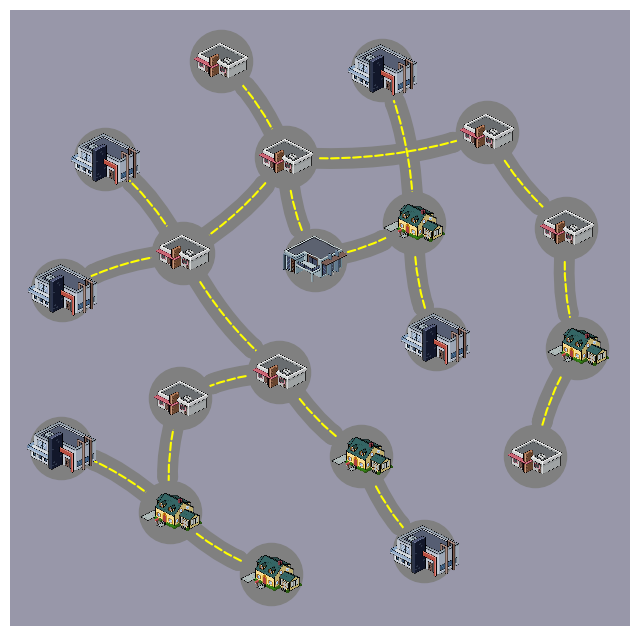

In [350]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
G = graph.getGraph()
custom_layout = layout

x_coords = [pos[0] for pos in custom_layout.values()]
y_coords = [pos[1] for pos in custom_layout.values()]
x_min, x_max = min(x_coords) * 1.2, max(x_coords) * 1.2
y_min, y_max = min(y_coords) * 1.2, max(y_coords) * 1.2

padding = 0.05
x_min, x_max = x_min - padding, x_max + padding
y_min, y_max = y_min - padding, y_max + padding

num_blocks_x = 100
num_blocks_y = 100
block_width = (x_max - x_min) / num_blocks_x
block_height = (y_max - y_min) / num_blocks_y
colors = ['#9897A9']
background = np.random.choice(colors, size=(num_blocks_x, num_blocks_y))

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(num_blocks_x):
    for j in range(num_blocks_y):
        rect = plt.Rectangle(
            (x_min + i * block_width, y_min + j * block_height),
            block_width,
            block_height,
            color=background[i, j]
        )
        ax.add_patch(rect)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='gray',
    width=15,
    arrowsize=0.01,
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_edges(
    G,
    custom_layout,
    ax=ax,
    edge_color='yellow',
    width=1.5,
    arrowsize=0.01,
    style="dashed",
    connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_nodes(
    G,
    custom_layout,
    ax=ax,
    node_color='gray',
    node_size=2000
)

nx.draw_networkx_labels(
    G,
    custom_layout,
    ax=ax,
    font_size=10,
    font_weight='bold'
)

for node, (x, y) in custom_layout.items():
    img_path = random.choice([
        {'path': 'images/constructions/house.png', 'zoom': 0.11},
        {'path': 'images/constructions/house2.jpg', 'zoom': 0.08},
        {'path': 'images/constructions/house3.jpg', 'zoom': 0.065},
        {'path': 'images/constructions/house4.jpg', 'zoom': 0.09},
    ])
    
    img = mpimg.imread(img_path['path'])
    imagebox = OffsetImage(img, zoom = img_path['zoom'])
    
    ab = AnnotationBbox(
        imagebox, (x, y),
        frameon=False,
        xycoords='data',
        xybox=(0, 0),
        boxcoords="offset points"
    )

    ax.add_artist(ab)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')

# Show the plot
plt.savefig('third_plot.png', dpi=300, bbox_inches='tight')
plt.show()